In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy
from scipy.optimize import minimize
from scipy.linalg import null_space

fsize = 15
lwidth = 3

## Uppgift 1

In [2]:
### some function needed to solve problem 1 ###

def wave_function(r, c):
    """Given the koefficient vector c and a grid r returns the resulting wave-function"""
    a = np.array([0.297104, 1.236745, 5.749982, 38.216677])
    wave = 0
    for i,c_i in enumerate(c):
        wave += c_i*np.exp(-a[i]*r**2)
    return wave

def init_Q():
    """Initializing the Q tensor"""
    a = np.array([0.297104, 1.236745, 5.749982, 38.216677])
    Q = np.zeros((4,4,4,4))
    for p in range(4):
        for r in range(4):
            for q in range(4):
                for s in range(4):
                    Q[p,r,q,s] = 2*np.pi**(5/2) / ( (a[p] + a[q])*(a[r] + a[s])*np.sqrt(a[p] + a[q] + a[r] + a[s]) )
    return Q

def normalize(c,sk):
    """Normalizing the C vector with koefficents to the wave-function"""
    b = c@sk@c
    c = c/np.sqrt(b)
    return c

def fock_operator2(c):
    """Returns the fock operator in two pieces consisting of the laplacian 1/r1 and the integral over r2\ 
and then also the the bit from the integral over both r1 and r2. Also retruns the matrix in the left\
 hand side in the generalized eigenvalue problem"""
    a = np.array([0.297104, 1.236745, 5.749982, 38.216677])
    sk = np.zeros((4,4))
    H = np.zeros((4,4))
    I = np.zeros((4,4))
    hk_3 = np.zeros((4,4))

    for p in range(4):
        for q in range(4):
            sk[p,q] = (np.pi/(a[p] + a[q]))**(3/2)
            
            H[p,q] = 3*a[q]*(np.pi/(a[q] + a[p]))**(3/2)*(1 - a[q]/(a[q]+ a[p]))
            H[p,q] += -4*np.pi/(a[q] + a[p])
            
            I[p,q] =  c@Q[p,:,q,:]@c
            
    return H, I , sk

def solve_fock_equation2(F,sk):
    """Solves the generalized eigenvalue problem and retorns the lowest\
eigenvalue together with the normalized eigenvalue"""

    w,v = scipy.linalg.eig(F,sk)
    sortOrder = np.argsort(w)
    w = w[sortOrder]
    v = v[:,sortOrder]
    c = normalize(v[:,0],sk)
    
    return np.real(w[0]),c


The resulting energy from the simulation become -2.85516039 a.u compered to the expected value -2.85516038 a.u. The simulation converged with accurace 4e-07 a.u after 12 itterations in the consistancy loop.
12


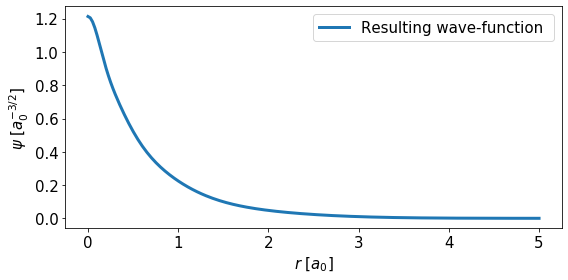

In [3]:
### make initial guess ###
c = np.array([1,1,1,1])
Q = init_Q()
H,I,sk = fock_operator2(c)
c = normalize(c,sk)

### start self consistency loop ###
e_old = 0
for i in range(100):
    H,I,sk = fock_operator2(c)
    F = H + I
    e,c = solve_fock_equation2(F,sk)
    e_new = c@(F+H)@c
    if (np.abs(e_new - e_old) < 1e-5/27.2):
        break
    e_old = e_new

### plot result ###
r_grid = np.linspace(0,5,200)
psi = wave_function(r_grid, c)
psi_T1 = np.abs(psi) 

fig,ax = plt.subplots(figsize = (8,4))
ax.plot(r_grid,np.abs(psi),Linewidth = lwidth, label = "Resulting wave-function ")
ax.legend(fontsize = fsize)
ax.set_xlabel("$r$ [$a_0$]", fontsize = fsize)
ax.set_ylabel(r"$\psi$ [$a_0^{-3/2}$]" , fontsize = fsize)
ax.tick_params(labelsize=fsize)

fig.tight_layout()
#fig.savefig("Task1_psi.pdf")

print(f"The resulting energy from the simulation become {e_new:.8f} a.u compered to the expected value -2.85516038 a.u.\
 The simulation converged with accurace {1e-5/26.6:.0e} a.u after {i} itterations in the consistancy loop.")
print(i)

# Uppgift 2

In [10]:
def make_derivativ_matrix(N,h):
    """Creats the matrix one obtain when discretize a second derivative"""
    U = -2*np.eye(N)
    for i in range(N):
        for j in range(N):
            if(np.abs(i - j) == 1):
                U[i,j] = 1
    return U/h**2

def solve_poisson_eq(r,u):
    """Solves the poisson equation on a the discretize r_grid for the discretize wave function psi"""
    N = len(r)
    h = r[1] - r[0] 
    r_int = r[1:N-1] # interior points
    
    ### set up equation ###
    A = make_derivativ_matrix(N-2,h)
    
    
    #u = np.sqrt(4*np.pi)*r_int*psi[1:N-1]
    u = u[1:N-1]
    
    B = -u**2/r_int
    
    ### solve equation for interior points ###
    U = np.linalg.solve(A,B)
    V = np.zeros(N)
    V[1:N-1] = U/r_int + 1/r_max
    
    ### add boundry condition ###
    V[0] = V[1]
    V[0] = 2
    V[N-1] = 1/r_max
    return V

C:\Miniconda3\envs\physics\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Miniconda3\envs\physics\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in subtract
  


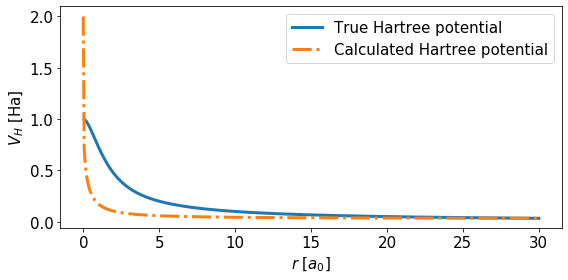

In [11]:
### set up grid ###
r_max = 30
N = 501
h = r_max/(N-1)
r_grid = np.linspace(0,r_max,N) # all points
VH = 1/r_grid - (1 + 1/r_grid)*np.exp(-2*r_grid)

### use s0 wave function and solve for the potential
psi = np.exp(-r_grid)/np.sqrt(np.pi)
V = solve_poisson_eq(r_grid,psi)

### plot result ###
fig,ax = plt.subplots(figsize = (8,4))
ax.plot(r_grid,VH,Linewidth = lwidth, label = "True Hartree potential")
ax.plot(r_grid,V,linestyle = "-.",Linewidth = lwidth, label = "Calculated Hartree potential")
ax.legend(fontsize = fsize)
ax.set_xlabel("$r$ [$a_0$]", fontsize = fsize)
ax.set_ylabel(r"$V_H$ [Ha]" , fontsize = fsize)
ax.tick_params(labelsize=fsize)

fig.tight_layout()
#fig.savefig("Task2_VH.pdf")

## Uppgift 3

In [12]:
def solve_kohn_sham(r, Vh, Vx, Vc,a):
    """Solve the kohn-sham equation for on the discretize r_grid with hartree, exchange and correlation potentials,\
     a can be given to change the strengt of the charge in the nuclei"""
    N = len(r)
    h = r[1] - r[0] 
    r_int = r[1:N-1] # interior points
    
    ### solve eigenvalue problem ###
    v = np.zeros((N,N-2))
    A = -1/2 * make_derivativ_matrix(N-2,h) - a*np.diag(1/r_int) + np.diag(Vh[1:N-1] + Vx[1:N-1] + Vc[1:N-1])
    w,v[1:N-1,:] = np.linalg.eig(A)

    ### set boundry condition ###
    v[0,:] = 0
    v[N-1,:] = 0
    
    ### Sort the eigenvalue and eigenvectors and normalize the first one according to L2-norm ###
    sortOrder = np.argsort(w)
    w = w[sortOrder]
    v = v[:,sortOrder] 
    a = np.trapz(np.abs(v[:,0])**2,r)
    
    return w,np.abs(v)/np.sqrt(a)

The energy becomes -0.49980


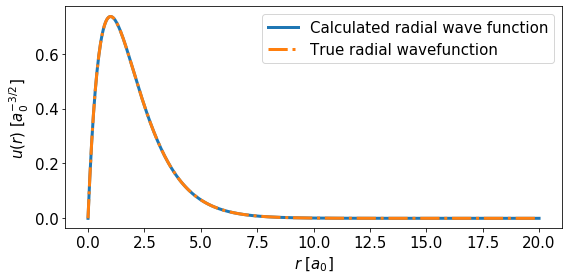

In [15]:
### set up grid ###
r_max = 20
N = 501
h = r_max/(N-1)
r_grid = np.linspace(0,r_max,N)
psi_true = np.exp(-r_grid)/np.sqrt(np.pi)

### solve kohn-sham for hydrogen atom ###
e,u = solve_kohn_sham(r_grid, np.zeros(N),np.zeros(N),np.zeros(N),1)
E0 = e[0]
print(f"The energy becomes {E0:.5f}")

### plot ###
fig,ax = plt.subplots(figsize = (8,4))
ax.plot(r_grid,np.abs(u[:,0]),Linewidth = lwidth, label = "Calculated radial wave function")
ax.plot(r_grid,np.sqrt(4*np.pi)*r_grid*psi_true, linestyle = "-.", Linewidth = lwidth, label = "True radial wavefunction")
ax.legend(fontsize = fsize)
ax.set_xlabel("$r$ [$a_0$]", fontsize = fsize)
ax.set_ylabel(r"$u(r)$ [$a_0^{-3/2}$]", fontsize = fsize)
ax.tick_params(labelsize=fsize)

fig.tight_layout()
#fig.savefig("Task3_u.pdf")

## Uppgift 4

In [19]:
def self_consist_looping(r,psi):
    u = np.sqrt(4*np.pi) * r *psi
    E_old = 0
    for i in range(200):
        V_H = solve_poisson_eq(r,u)
        e,u = solve_kohn_sham(r,V_H, np.zeros(len(r)),np.zeros(len(r)),2)
        
        u = u[:,0]
        
        E_new = 2*e[0] - 2*np.trapz(u**2 * 1/2*V_H , r)
        diff = np.abs(E_new-E_old)
        if(diff < 1e-5/27.2):
            break
        E_old = E_new
#         plt.plot(u)
#         plt.show()
    return E_new,u,diff

def converge_rmax(r_max,N,h):
    E = np.zeros(200)
    
    for i in range(1,200):
        r_grid = np.linspace(0,r_max,N)
        psi = np.exp(-r_grid)/np.sqrt(np.pi)
        
        E[i],u,c = self_consist_looping(r_grid,psi)
        diff = np.abs(E[i] - E[i-1])
        if diff < 1e-5/27.2:
            Energy = E[0:i+1]
            break
        print(E[i],diff,r_max,N)
        r_max += 5 
        N += 5/h

    return Energy, u, diff, r_max, N

def converge_E():
    return

In [ ]:
### set up grid ###
r_max = 5
N = 201
h = r_max/(N-1)
r_grid = np.linspace(0,r_max,N)
psi = np.exp(-2*r_grid)/np.sqrt(np.pi) # s0 initial guess

### Self consistantly looping untill energy change is less then 1e-5 eV ###
E1,u1,diff1 = converge_rmax(r_max,N,h)

print(diff1)
plt.plot(E1)
#plt.plot(u1)


-2.8593085656181154 2.8593085656181154 5 201


C:\Miniconda3\envs\physics\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


-2.7596016207403964 0.09970694487771903 10 401.0
-2.7262682885295826 0.033333332210813804 15 601.0
-2.7096016218622587 0.01666666666732386 20 801.0
-2.699601621860935 0.010000000001323617 25 1001.0
-2.6929349551764856 0.006666666684449485 30 1201.0
-2.6881730504387686 0.004761904737716982 35 1401.0
-2.684601621867097 0.0035714285716714755 40 1601.0


In [16]:
a = 1/0
print(a)

ZeroDivisionError: division by zero